## Load/import packages

In [2]:
import json
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from os import listdir, mkdir
from os.path import splitext
from os.path import join
from skimage import io, color

%matplotlib inline

# Check if Tensorflow uses GPU
print(tf.config.experimental.list_physical_devices('GPU'))

#Limit GPU memory usage
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print()
print(f"Tensorflow Version: {tf.__version__}")
print(f"Numpy Version: {np.__version__}")
# print(f"OpenCV Version: {cv2.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"Keras Version: {tf.keras.__version__}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Tensorflow Version: 2.4.0-rc0
Numpy Version: 1.19.2
Matplotlib Version: 3.3.1
Keras Version: 2.4.0


# Load datasets

In [3]:
AW2_train_dir = r"D:\Aff-Wild2 Dataset\Aff-wild2\Sets_per_class\mini_train"
AW2_norm_minitrain = image_dataset_from_directory(directory = AW2_train_dir,
                                              labels="inferred",
                                              label_mode="categorical",
                                              shuffle=False,
                                              color_mode='rgb',
                                              batch_size=5,
                                             image_size=(112, 112))

Found 107413 files belonging to 7 classes.


In [6]:
AW2_val_dir = r"D:\Aff-Wild2 Dataset\Aff-wild2\Sets_per_class\val"
AW2_norm_val = image_dataset_from_directory(directory = AW2_val_dir,
                                              labels="inferred",
                                              label_mode="int",
                                              shuffle=False,
                                              color_mode='rgb',
                                              batch_size=24,
                                             image_size=(112, 112))

Found 319323 files belonging to 7 classes.


In [5]:
type(AW2_norm_minitrain)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [6]:
# Pull the first batch of 7 images
count = 0
for element in AW2_norm_minitrain:
    if count == 1:
        break
    count+=1
    values = element

In [7]:
print(values[0].shape)
print(values[1].shape)

(5, 112, 112, 3)
(5, 7)


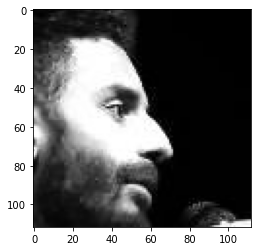

In [8]:
plt.imshow(values[0].numpy()[0].astype(int))

In [7]:
# import keras_video
# # glob_pattern='./_test/{classname}/*'

# gen = keras_video.VideoFrameGenerator(batch_size=4, nb_frames=24, glob_pattern=r'D:\Aff-Wild2 Dataset\Aff-wild2\Sets_per_class\mini_train\{classname}\*')

In [8]:
# from keras_video import utils as ku

In [9]:
# keras_video.VideoFrameGenerator

# Initiate Base CNN
For the feature extraction the pre-trained **VGG19** network will be used with the imagenet weights. Input shape is set to 112,112,3

In [15]:
base_VGG19 = tf.keras.applications.MobileNetV2(include_top=False, 
                                         weights='imagenet', 
                                         input_shape=(112,112,3))

In [16]:
base_VGG19.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 56, 56, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 56, 56, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 56, 56, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [17]:
# Setup up model with base_VGG19 and all those layers frozen
# Define the sequence input size
shape = (5,112,112,3)
def build_model(inp_shape):
    model = Sequential(name='CNN-RNN')
    model.add(layers.TimeDistributed(base_VGG19, input_shape = inp_shape, name='VGG19'))
    base_VGG19.trainable = False
    model.add(layers.TimeDistributed(layers.Flatten(), name='Flatten'))
    model.add(layers.LSTM(64,return_sequences=True, name='LSTM_1'))
    model.add(layers.Dense(7,activation='softmax', name='Dense_Output'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

In [18]:
cnn_rnn_LSTM = build_model(shape)
cnn_rnn_LSTM.summary()

Model: "CNN-RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VGG19 (TimeDistributed)      (None, 5, 4, 4, 1280)     2257984   
_________________________________________________________________
Flatten (TimeDistributed)    (None, 5, 20480)          0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 5, 64)             5259520   
_________________________________________________________________
Dense_Output (Dense)         (None, 5, 7)              455       
Total params: 7,517,959
Trainable params: 5,259,975
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
AW2_norm_minitrain = AW2_norm_minitrain.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

history = cnn_rnn_LSTM.fit(AW2_norm_minitrain.batch(16, drop_remainder=True), epochs = 1, verbose = 1)

1097/1342 [=======================>......] - ETA: 1:00 - loss: 0.9835 - acc: 0.7867